In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas
import xarray
import cftime
import tensorflow as tf

/Users/paulag/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [353]:
datapath = 'nino34_monthly.nc'
nino34 = xarray.open_dataset(datapath, decode_times = False)
print(nino34)
nino34 = np.array((nino34['nino34'].values)[12 * 50:])

<xarray.Dataset>
Dimensions:         (bounds: 2, month: 12, time: 7800)
Coordinates:
  * time            (time) float64 15.5 45.0 74.5 ... 2.372e+05 2.372e+05
Dimensions without coordinates: bounds, month
Data variables:
    nino34          (time) float64 ...
    time_bnds       (time, bounds) float64 ...
    areacello       float32 ...
    days_per_month  (month) int32 ...


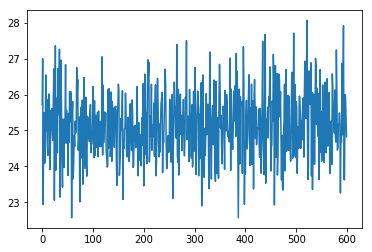

In [354]:
plt.plot(nino34[::12]);

In [355]:
def ONI(nino34, m = 3):
    oni = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        oni[i] = np.mean(nino34[max(0, (i - m + 1)) : min((i + 1), length)])
    return oni

In [356]:
oni = ONI(nino34)

In [357]:
def climatology(nino34):
    clm = np.zeros(12)
    length = nino34.shape[0]
    for month in range(12):
        section = [12 * i + month for i in range(length // 12)]
        clm[month] = np.mean(nino34[section])
    return clm

In [358]:
clm = climatology(nino34)

In [359]:
def SST_anomaly(nino34, clm):
    anm = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        anm[i] = nino34[i] - clm[i % 12]
    return anm

In [360]:
anm = SST_anomaly(nino34, clm)
oanm = ONI(anm)

# Data Preparation

In [361]:
T = 7      # prediction timeline
H = 48   # history used for prediction
include_month = 1           # 1 if we use the month as a feature, 0 otherwise
threshold = 0.5         
signal = np.array(nino34)   # data used for training/testing
length = signal.shape[0]    # number of data points

mean = np.mean(signal)
std = np.std(signal)

signal = (signal - mean) / std

In [362]:
np.random.seed(0)

size = length - H - T       # effective dataset size
        
# create the 'history matrix'
data = np.ndarray((size, H + include_month))
for i in range(size):
    if(include_month == False):
         data[i] = signal[i:(i + H)]
    else:
        data[i] = np.append(signal[i:(i + H)], (i + H + T) % 12)

labels = np.ndarray((size), dtype = np.float64)
        
for i in range(size):
    labels[i] = anm[i + H + T]

split = size // 10      
shuffle = np.random.permutation(size)
train_ind = np.array(shuffle[0: 8 * split])
val_ind = np.array(shuffle[8 * split: 9 * split])
test_ind = np.array(shuffle[9 * split: size])

train = np.array(data[train_ind])
train_labels = np.array(labels[train_ind])

val = np.array(data[val_ind])
val_labels = np.array(labels[val_ind])

test = np.array(data[test_ind])
test_labels = np.array(labels[test_ind])

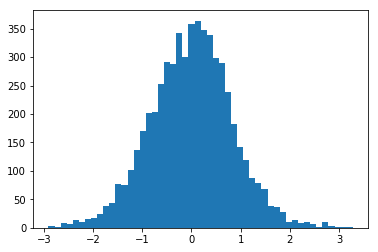

In [363]:
plt.hist(train_labels, bins=50);

# Simple Model

In [ ]:
mse = {}
mae = {}

for N1 in [H * 4, H * 8, H * 16]:
    for N2 in [H * 8, H * 16]:
        for N3 in [H * 8, H * 16, H * 32]:
            for d in [0, 0.2, 0.5]:
                for e in [50, 60, 70]:
                    model = tf.keras.models.Sequential([
                      tf.keras.layers.Dense(N1,  kernel_initializer='normal', activation = tf.nn.relu),
                      tf.keras.layers.Dropout(d),
                      tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                      tf.keras.layers.Dropout(d),
                      tf.keras.layers.Dense(N3,  kernel_initializer='normal', activation = tf.nn.relu),
                      tf.keras.layers.Dropout(d),
                      tf.keras.layers.Dense(1,  kernel_initializer='normal', activation = 'linear')
                    ])

                    model.reset_states()

                    model.compile(optimizer='adam',
                        loss='mae',
                        metrics=['mse', 'mae'])

                    model.fit(train_n, train_labels, epochs = e, verbose = 0)
                    (loss, mse[(N1, N2, N3, d, e)], mae[(N1, N2, N3, d, e)]) = model.evaluate(val_n, val_labels, verbose = 0)
    
                    print(N1, N2, N3, d, e, mse[(N1, N2, N3, d, e)], mae[(N1, N2, N3, d, e)])

In [328]:
best_models = {k:v for (k,v) in mse.items() if v < 0.3}
print(best_models)

{}


In [364]:
(N1, N2, N3, d) = (192, 768, 768, 0.5)
epochs = 60

model = tf.keras.models.Sequential([
                  tf.keras.layers.Dense(N1,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N3,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(1,  kernel_initializer='normal', activation = 'linear')
        ])

model.reset_states()

model.compile(optimizer='adam',
                    loss='mae',
                    metrics=['mse', 'mae'])

model.fit(train, train_labels, epochs = epochs, verbose = 1)
(loss, mse, mae) = model.evaluate(val, val_labels, verbose = 0)

print(mse, mae)

Epoch 1/60
5712/5712 [==============================] - 16s 3ms/step - loss: 0.6229 - mean_squared_error: 0.6427 - mean_absolute_error: 0.6229
Epoch 2/60
5712/5712 [==============================] - 3s 498us/step - loss: 0.5891 - mean_squared_error: 0.5823 - mean_absolute_error: 0.5891
Epoch 3/60
5712/5712 [==============================] - 3s 525us/step - loss: 0.5701 - mean_squared_error: 0.5546 - mean_absolute_error: 0.5701
Epoch 4/60
5712/5712 [==============================] - 3s 518us/step - loss: 0.5579 - mean_squared_error: 0.5388 - mean_absolute_error: 0.5579
Epoch 5/60
5712/5712 [==============================] - 3s 525us/step - loss: 0.5518 - mean_squared_error: 0.5313 - mean_absolute_error: 0.5518
Epoch 6/60
5712/5712 [==============================] - 3s 526us/step - loss: 0.5418 - mean_squared_error: 0.5135 - mean_absolute_error: 0.5418
Epoch 7/60
5712/5712 [==============================] - 3s 523us/step - loss: 0.5276 - mean_squared_error: 0.4953 - mean_absolute_error: 

5712/5712 [==============================] - 3s 487us/step - loss: 0.1359 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1359
Epoch 58/60
5712/5712 [==============================] - 3s 479us/step - loss: 0.1329 - mean_squared_error: 0.0339 - mean_absolute_error: 0.1329
Epoch 59/60
5712/5712 [==============================] - 3s 480us/step - loss: 0.1299 - mean_squared_error: 0.0323 - mean_absolute_error: 0.1299
Epoch 60/60
5712/5712 [==============================] - 3s 480us/step - loss: 0.1292 - mean_squared_error: 0.0322 - mean_absolute_error: 0.1292
0.2849385405288023 0.3742416983559018


In [365]:
pred = model.predict(train)

In [366]:
print(mean_squared_error(train_labels, pred))
print(mean_absolute_error(train_labels, pred))

0.027207364342823618
0.1175153800325288


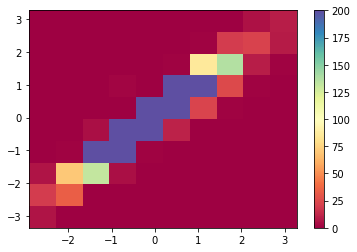

In [367]:
plt.hist2d(train_labels, pred[:,0], cmap = plt.cm.Spectral, vmax = 200);
plt.colorbar();

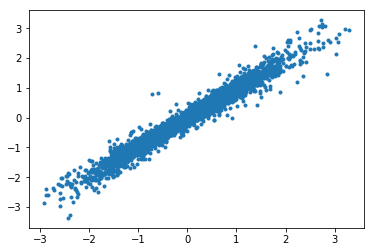

In [368]:
plt.plot(train_labels, pred[:,0], ".");

In [376]:
pred_val = model.predict(val)

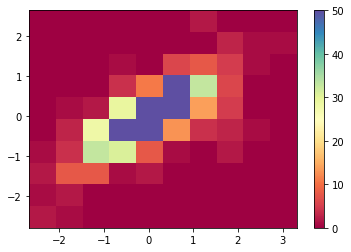

In [377]:
plt.hist2d(val_labels, pred_val[:,0], cmap = plt.cm.Spectral, vmax = 50);
plt.colorbar();

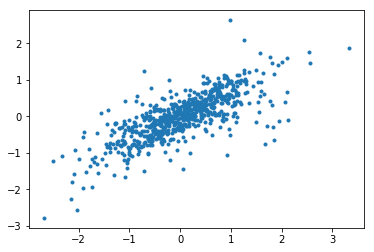

In [378]:
plt.plot(val_labels, pred_val[:,0], ".");

In [379]:
def correlation(x, y):
    x0 = x - np.mean(x)
    y0 = y - np.mean(y)
    return np.mean(x0 * y0) / np.sqrt((np.mean(x0**2) * (np.mean(y0**2))))

In [380]:
print(correlation(train_labels, pred[:,0]))
print(correlation(val_labels, pred_val[:,0]))

0.9802368390632005
0.7608888004764556


# Simple Regressors

In [282]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor()
model.fit(train_n,train_labels)

# Get the mean absolute error on the validation data
predicted = model.predict(val_n)
MAE = mean_absolute_error(val_labels , predicted)
MSE = mean_squared_error(val_labels , predicted)
print(MAE, MSE)

0.6176734146537877 0.6202964910510118


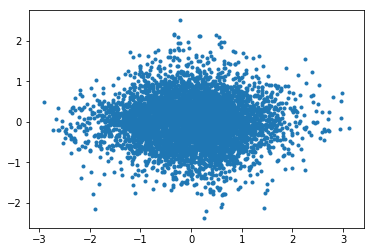

In [283]:
plt.plot(oanm[train_ind], model.predict(train_n), ".");

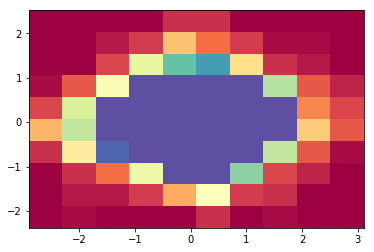

In [284]:
plt.hist2d(oanm[train_ind], model.predict(train_n), cmap = plt.cm.Spectral, vmax = 50);

In [285]:
from sklearn import svm

model = svm.SVR()
model.fit(train_n,train_labels)

predicted = model.predict(val_n)
MAE = mean_absolute_error(val_labels , predicted)
MSE = mean_squared_error(val_labels , predicted)

print(MAE, MSE)

0.5938722116974713 0.5962853868385536


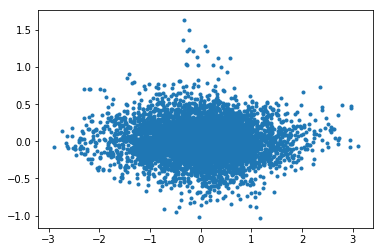

In [286]:
plt.plot(oanm[train_ind], model.predict(train_n), ".");

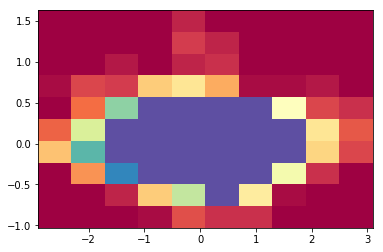

In [287]:
plt.hist2d(oanm[train_ind], model.predict(train_n), cmap = plt.cm.Spectral, vmax = 50);